In [18]:
from self_supervised_halos.utils.utils import data_postprocess_path, check_cuda
from scripts.classification_2d import ClassificationModel, report_classification_performance

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = check_cuda()

CUDA is not available.
Device: cpu


In [19]:
dataset = HaloDataset(root_dir=data_postprocess_path,subhalos_df=subhalos_df, 
                      load_2d=True, load_3d=False, load_mass=False,
                        choose_two_2d = False,
                      DEBUG_LIMIT_FILES = None)

if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Preparing 2D data: 100%|██████████| 16544/16544 [00:38<00:00, 430.33it/s]

Batch size: 128


In [29]:
lr = 1e-2
n_epochs=5


criterion = nn.CrossEntropyLoss(weight=dataset.mass_bins_weights.to(device)).to(device)

model = ClassificationModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':10, 'gamma':0.1},
                    criterion=criterion,
                    history=None
)


model.trial_forward_pass(train_loader, device);

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.256624460220337
Outputs shape: torch.Size([128, 10])


In [4]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=val_loader,
    num_epochs=n_epochs, 
    device=device)

Epoch 1/5 Training: 100%|██████████| 78/78 [00:06<00:00, 11.94it/s]


Epoch 1, Training Loss: 1.1470020913924925


Epochs:  20%|██        | 1/5 [00:07<00:30,  7.54s/it]

Epoch 1, Validation Loss: 0.7690550960027255


Epoch 2/5 Training: 100%|██████████| 78/78 [00:05<00:00, 14.02it/s]


Epoch 2, Training Loss: 0.5345076628220387


Epochs:  40%|████      | 2/5 [00:14<00:21,  7.05s/it]

Epoch 2, Validation Loss: 0.5394843679208022


Epoch 3/5 Training: 100%|██████████| 78/78 [00:07<00:00, 10.89it/s]


Epoch 3, Training Loss: 0.4153423723884118


Epochs:  60%|██████    | 3/5 [00:22<00:15,  7.64s/it]

Epoch 3, Validation Loss: 0.2802710716540997


Epoch 4/5 Training: 100%|██████████| 78/78 [00:07<00:00, 10.01it/s]


Epoch 4, Training Loss: 0.34341955528809476


Epochs:  80%|████████  | 4/5 [00:32<00:08,  8.45s/it]

Epoch 4, Validation Loss: 0.31779841448252016


Epoch 5/5 Training: 100%|██████████| 78/78 [00:05<00:00, 14.19it/s]


Epoch 5, Training Loss: 0.34184900117226136


Epochs: 100%|██████████| 5/5 [00:38<00:00,  7.77s/it]

Epoch 5, Validation Loss: 1.0910246188823993


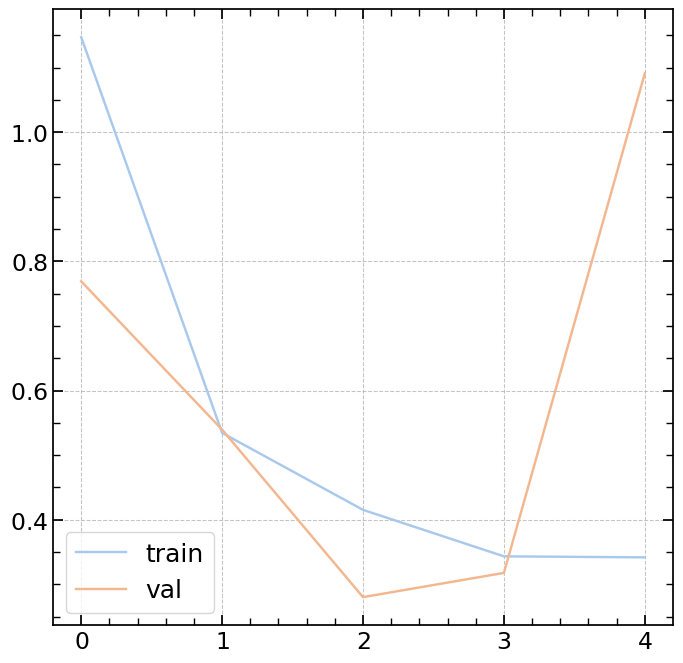

In [11]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

In [12]:
#test saving
model.save(0,0)

Model Classification_2d saved at epoch 0


In [16]:
from scripts.base_model import report_classification_performance, pd

result_df = report_classification_performance(model, val_loader, device=device)

pd.crosstab(result_df['true_class'], result_df['pred_class'])


Classification Performance: 26it [00:00, 27.16it/s]


pred_class,0,1,2,3,4,5,6,7
true_class,,,,,,,,
0,967,806,2,0,0,0,0,0
1,0,588,248,1,0,0,0,0
2,0,0,225,167,1,0,0,0
3,0,0,0,68,93,0,0,0
4,0,0,0,0,40,34,0,0
5,0,0,0,0,0,14,26,5
6,0,0,0,0,0,0,3,10
7,0,0,0,0,0,0,0,8
8,0,0,0,0,0,0,0,2
